In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
import biogeme.vns as vns
import biogeme.database as db

# Pareto reader

This notebook is used to display the information contained in the Pareto set generated by the algorithm, and saved in the pickle file. 

We need the following just to know the sample size. 

In [2]:
df = pd.read_csv('optima.dat', sep='\t')

database = db.Database('optima', df)

globals().update(database.variables)

exclude = ((Choice == -1) + (CostCarCHF < 0)) > 0
database.remove(exclude)

sampleSize = database.getSampleSize()
sampleSize

1906

The information about the approximation of the Pareto set is saved regularly by the algorithm in a pickle file. We first open it. 

In [3]:
pickleFile = 'optimaPareto.pickle'

The first argument is the largest size of neighborhood used by the algorithm. It is irrelevant when the algorithm is not executed. Here, we simply display the Pareto solutions. So it is not needed.

In [4]:
pareto = vns.paretoClass(_, archiveInputFile=pickleFile)

In [5]:
print(f'Number of pareto solutions: {len(pareto.pareto)}')

Number of pareto solutions: 34


We calculate the AIC and the BIC for each non dominated  model.

In [6]:
def AIC(k, LL):
    """Calculate the Aikaike Information Criterion for a model with k parameters and final log liklelihood LL"""
    return 2 * k - 2 * LL

In [7]:
def BIC(k, LL):
    """Calculate the Bayesian Information Criterion for a model with k parameters and final log liklelihood LL"""
    return k * np.log(sampleSize) - 2 * LL


## List of Pareto solutions: performance measures

For each model in the Pareto set, we display:

- an id,
- the negative log likelihood,
- the number of parameters,
- the Bayesian information criterion (BIC), 
- the Akaike informatoin criterion (AIC).

The models with the best BIC (B*) and the best AIC (A*) are identified. If the same model has both the best BIC and AIC, it is labeled (**). 

In [8]:
bestBIC = None
bestAIC = None
summary = []
besti = -1
bestj = -1
for p in pareto.pareto:
    res = ''
    for t, r in zip(p.objectivesNames, p.objectives):
        res += f'{t}: {r}\t'
    L = p.objectives[0]
    k = p.objectives[1]
    A = AIC(k, -L)
    B = BIC(k, -L)
    res += f'BIC = {B:.3f}\tAIC = {A:.3f}'
    summary.append(res)
    if bestBIC is None or B < bestBIC:
        bestBIC = B
        besti = len(summary) - 1
    if bestAIC is None or A < bestAIC:
        bestAIC = A
        bestj = len(summary) - 1
for i in range(len(summary)):
    if i == besti:
        if i == bestj:
            pre = f'{i+1:3} **'
        else:
            pre = f'{i+1:3} B*'
    elif i == bestj:
        pre = f'{i+1:3} A*'
    else:
        pre = f'{i+1:3}   '
    print(f'{pre} {summary[i]}')

  1    Neg. log likelihood: 1235.742810736561	#parameters: 4	BIC = 2501.697	AIC = 2479.486
  2    Neg. log likelihood: 1127.4185480533592	#parameters: 5	BIC = 2292.601	AIC = 2264.837
  3    Neg. log likelihood: 1104.8322909668	#parameters: 6	BIC = 2254.981	AIC = 2221.665
  4    Neg. log likelihood: 1060.9350080934967	#parameters: 10	BIC = 2197.398	AIC = 2141.870
  5    Neg. log likelihood: 1080.2041035076786	#parameters: 8	BIC = 2220.830	AIC = 2176.408
  6    Neg. log likelihood: 1049.3525193818766	#parameters: 11	BIC = 2181.785	AIC = 2120.705
  7    Neg. log likelihood: 969.9960089497033	#parameters: 30	BIC = 2166.575	AIC = 1999.992
  8    Neg. log likelihood: 1069.2360853787256	#parameters: 9	BIC = 2206.447	AIC = 2156.472
  9    Neg. log likelihood: 1093.1358215961525	#parameters: 7	BIC = 2239.141	AIC = 2200.272
 10    Neg. log likelihood: 1040.6455154331948	#parameters: 12	BIC = 2171.924	AIC = 2105.291
 11    Neg. log likelihood: 1028.608553639897	#parameters: 14	BIC = 2162.956	AIC 

## List of Pareto solutions: model specifications

For each model in the Pareto set, we provide a description of the model specification.

In [9]:
counter = 0 
for p in pareto.pareto:
    counter += 1
    print(f'*************** Model {counter} ************************')
    print(p)
    print('\n')
    

*************** Model 1 ************************
Logit-------------------
Alternative pt [0]
-------------------
Cte. 
PT travel time_sqrt [generic] 



--------------------
Alternative car [1]
--------------------
Cte. 
Car travel time_sqrt [generic] 

-------------------
Alternative sm [2]
-------------------
Distance [alt. spec.] 

Neg. log likelihood: 1235.742810736561
#parameters: 4


*************** Model 2 ************************
Logit-------------------
Alternative pt [0]
-------------------
Cte. 
PT travel time_sqrt [generic] 
PT travel cost_sqrt [generic] 


--------------------
Alternative car [1]
--------------------
Cte. 
Car travel time_sqrt [generic] 
Car travel cost_sqrt [generic] 
-------------------
Alternative sm [2]
-------------------
Distance [alt. spec.] 

Neg. log likelihood: 1127.4185480533592
#parameters: 5


*************** Model 3 ************************
Logit-------------------
Alternative pt [0]
-------------------
Cte. 
PT travel time [generic] 
PT trav

## List of Pareto solutions: illustration

The plot below illustrates all models considered by the algorithm. Each model corresponds to one point in the graph. 

- The x-coordinate corresponds to the negative log likelihood of the model, and the y-coordinate to the number of parameters. 
- The larger circles correspond to all models that are not dominated. They are in the Pareto set.
- The crosses corresponds to model that happened to be non dominated at some point during the course of the algorithm, but have been removed from the Pareto set afterwards, as a dominating model has been identified.
- Finally, the small dots corresponds to models that have been considered, but rejected because dominated by another model already in the set.

In [10]:
objectives = list(pareto.pareto)[0].objectivesNames
objectives

['Neg. log likelihood', '#parameters']

In [11]:
par_obj = [p.objectives for p in pareto.pareto]
par_x, par_y = zip(*par_obj)

In [12]:
con_obj = [p.objectives for p in pareto.considered]
con_x, con_y = zip(*con_obj)

In [13]:
rem_obj = [p.objectives for p in pareto.removed]
rem_x, rem_y = zip(*rem_obj)

In [14]:
x_buffer = 10
y_buffer = 0.1

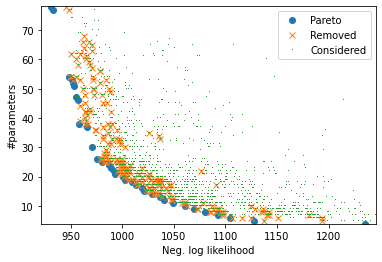

In [15]:
plt.axis([min(par_x)-x_buffer,
          max(par_x)+x_buffer,
          min(par_y)-y_buffer,
          max(par_y)+y_buffer])
plt.plot(par_x, par_y, 'o', label='Pareto')
plt.plot(rem_x, rem_y, 'x', label='Removed')
plt.plot(con_x, con_y, ',', label='Considered')
plt.xlabel(objectives[0])
plt.ylabel(objectives[1])
plt.legend()